In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env = gym.make(envs[-2]).unwrapped


discrete_actions = False

if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
    
import gc

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_num = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
input_num = output_num*2
all_a = 0#.0001

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def evolve(population,population_out_size,gen,p_fitness,mutation_rate,mutation_scale):
    #Chose creatures based on fitness
    sort = np.argsort(np.max(p_fitness)-p_fitness)
    choice = []
    for i in range(population_out_size+1):
        ex = (population_out_size)/3
        ex = ex**(1/(i+1))
        for _ in range(int(ex)):
            choice.append(sort[i%(len(p_fitness)-1)])
        if len(choice) > population_out_size+1:
            choice = choice[:population_out_size+1]
            break
    np.random.shuffle(choice)
    
    #mate and mutate creatures
    new_population = []
    for p in range(population_out_size):
        #Pick parents
        first_choice = population[choice[p]]
        second_choice = population[choice[p+1]]
        
        child = mate(env,creature_out_size,all_a,device,first_choice,second_choice,
                     mutation_rate[choice[p]],mutation_rate[choice[p+1]],gen,mutation_scale).to(device)
        
        new_population.append(child)
        
    return new_population

In [3]:

def train_gan(population,p_fitness,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    gen_loss_all = []
    dis_loss_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(len(population))
        np.random.shuffle(ind)
        population = np.array(population)[ind]
        p_fitness = p_fitness[ind]
        for i in range(len(population)//batch_size):
            #turn population into vectors
            real_batch = []
            for b in range(batch_size):
                real_batch.append(get_params(population[(i*batch_size)+b]).unsqueeze(0))
            real_batch = torch.cat(real_batch, dim=0).to(device)
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            dis_out_r = dis(real_batch).squeeze(-1)
            rank = p_fitness[i*batch_size:(i*batch_size)+batch_size]
            dis_error_real = (nn.MSELoss()(dis_out_r,rank))
            dis_error_real.backward()
            dis_optimizer.step() 
            
            #generate children from population
            child = gen_children(population,device,gen,batch_size,a = all_a)
            
            #train generator
            dis_out_f = dis(child).squeeze(-1)
            gen_optimizer.zero_grad()
            gen_error = -torch.mean(dis_out_f)
            gen_error.backward()
            gen_optimizer.step() 
            
            #keep losses to draw graph   
            gen_loss_all.append(gen_error)
            dis_loss_all.append(dis_error_real)   
            
    return gen_loss_all, dis_loss_all

def softmax(x):
    e = 2.71828
    return e ** (x - max(x)) / sum(e**(x - max(x)))

starting training
2904
Measured population fitness : 2s
population fitness : [ -92.72986811 -102.83088526  -24.93750215 -113.8497171   -97.33813566
  -29.72168427 -113.62030754  -94.23656837 -114.03204974  -98.3934452 ]
mean fit : -88.16901633899514
Trained GAN : 0s
Evolved : 0s


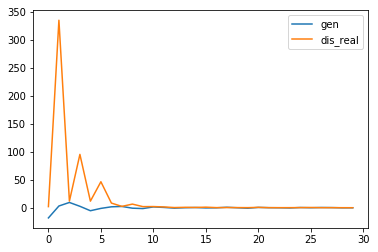

Generation 1  fitness : -24.9375021524975
#################################
Measured population fitness : 5s
population fitness : [ -60.34291751 -117.45340705  -24.68710228 -117.79015962  -41.30810987
  -19.5319541   -98.59141957  -99.77923645 -113.87207596  -99.71082478]
mean fit : -79.30672071936124
Trained GAN : 0s
Evolved : 0s


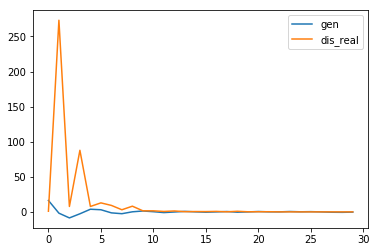

Generation 2  fitness : -19.531954098992713
#################################
Measured population fitness : 5s
population fitness : [-104.83250259 -100.75524851  -93.34147646  -19.75985331 -114.72548814
  -59.50430266 -100.21584481  -70.33502306  -99.78454188 -116.75599394]
mean fit : -88.00102753655509
Trained GAN : 0s
Evolved : 0s


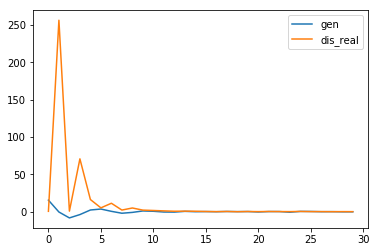

Generation 3  fitness : -19.759853314063022
#################################
Measured population fitness : 1s
population fitness : [-101.4507232   -93.92091743 -114.87267734 -122.98169941  -94.38166865
  -81.99476045 -112.70930685 -106.55169023 -111.65977374 -121.03024501]
mean fit : -106.15534623227593
Trained GAN : 0s
Evolved : 0s


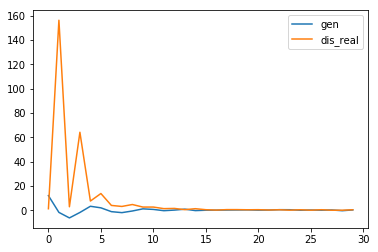

Generation 4  fitness : -81.99476045142994
#################################
Measured population fitness : 3s
population fitness : [-107.76985045  -95.97989783  -98.88958589  -26.74770046 -112.74617573
  -56.78034914  -92.16867296 -108.47254332 -102.086926   -115.73812137]
mean fit : -91.73798231582933
Trained GAN : 0s
Evolved : 0s


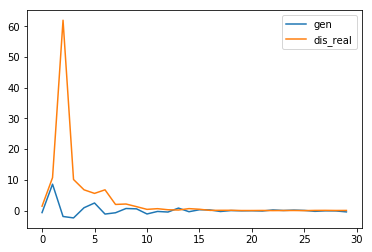

Generation 5  fitness : -26.74770046264231
#################################
Measured population fitness : 3s
population fitness : [-123.32592151  -16.84963428 -111.88683783  -72.80763511 -132.91000157
 -127.42024398 -107.78215759  -19.63929227  -94.49290122 -109.72363024]
mean fit : -91.68382555966251
Trained GAN : 0s
Evolved : 0s


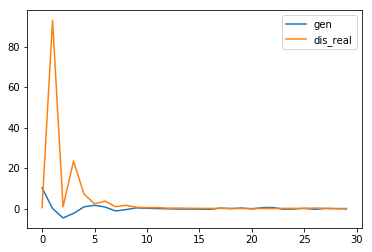

Generation 6  fitness : -16.849634281381235
#################################
Measured population fitness : 9s
population fitness : [ -82.01938931  -56.01834825 -106.56059879 -128.74989371  -40.52848516
 -112.54104936  -18.84367662  -56.18406778 -125.12797949  -81.23653217]
mean fit : -80.78100206424091
Trained GAN : 1s
Evolved : 0s


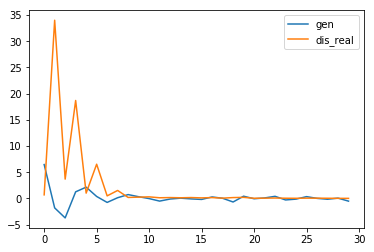

Generation 7  fitness : -18.843676622115005
#################################
Measured population fitness : 6s
population fitness : [ -15.00367137  -50.71998537 -113.04629702 -112.49390491 -113.57192425
  -91.74577891 -115.00729537 -110.47079529 -116.25996646  -72.25520144]
mean fit : -91.05748204010162
Trained GAN : 0s
Evolved : 0s


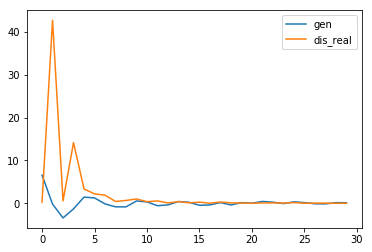

Generation 8  fitness : -15.00367137397133
#################################
Measured population fitness : 6s
population fitness : [-117.46800102  -67.644967   -122.77979296 -145.56028818 -120.94378506
  -67.87726968 -114.0819981  -114.01067989  -50.31148156 -112.49873943]
mean fit : -103.31770028643386
Trained GAN : 1s
Evolved : 0s


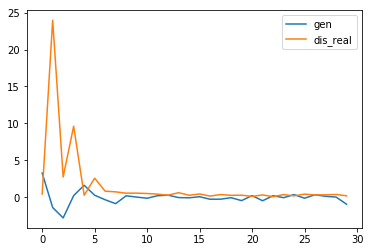

Generation 9  fitness : -50.311481556796835
#################################


In [ ]:
population_size = 10
max_population = population_size
max_population_batch = 2
batch_size = population_size
out_size = population_size
n_generations = 300000

#randomly inititialise starting population
population = []
for p in range(population_size):
    population.append(Creature(env.observation_space.shape[0],creature_out_size).to(device))

gen = Generator(input_num,output_num,device).to(device)
dis = Discriminator().to(device)

print("starting training")
print(len(get_params(Creature(env.observation_space.shape[0],creature_out_size))))

old_population = []
old_fitnesses = []
for i in range(n_generations):
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002,betas=(0.5,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.001,betas=(0.5,0.999))
   
    start_time = time.time()
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))

    #setup data for GAN
    population_batch = np.concatenate(np.array(old_population))
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    
    #normalize fitnesses
    epsilon = 0.000001
    fitness_batch = ((fitness_batch - np.mean(fitness_batch))/np.sqrt(np.var(fitness_batch)+epsilon))
    
    #Train GAN
    start_time = time.time()
    gen_loss, dis_loss = train_gan(population_batch,fitness_batch,
              batch_size =min(batch_size,len(population_batch)//2),n_epochs = 15)
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
    
    #Scale of normal distribution used for mutation
    mutation_scale = 0.2
    mutation_rate = 0.7
    mutation_rate = np.random.choice([0.2, 0], p_fitness_.shape,p=[mutation_rate,1-mutation_rate])
    mutation_rate[np.argsort(p_fitness_)[(p_fitness_.size-len(population)//3):]] = 0
    
    #progressively grow population at start
    if out_size < max_population:
        out_size+=2
    
    #mate and mutate population
    start_time = time.time()
    population = evolve(population,out_size,gen,p_fitness_,
                                        mutation_rate,mutation_scale)
    print("Evolved : {}s".format(int(time.time() - start_time)))
    
    plt.plot(gen_loss,label='gen')
    plt.plot(dis_loss,label='dis_real')
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")


In [ ]:
env = gym.make(envs[-2]).unwrapped

p_fitness = measure_population_fitness(population,env,device,discrete_actions,min_reward=-100,
                                                             max_steps = 200)

fitness = measure_fitness(population[np.argmax(p_fitness)],env,device,discrete_actions,min_reward=-100,
                                  render = True,max_steps = 5000000)
print(fitness)